In [ ]:
import cv2
import os
import shutil

# --- Configuration for Frame Extraction ---
# ==============================================================================
# IMPORTANT: SET YOUR PATHS HERE!
# 1. The path to your dataset containing the 'Violence' and 'NonViolence' video folders.
VIDEO_DATASET_PATH = r"/media/rajendraprasath-m/New Volume/Projects/Final Year Project/Data/Video/Real Life Violence Dataset/Train"
# 2. The path to the NEW, EMPTY folder where the extracted frames will be saved.
FRAME_OUTPUT_PATH = r"/media/rajendraprasath-m/New Volume/Projects/Final Year Project/Data/Video/Extracted_Frames"
# ==============================================================================

# Define the names of your class folders
CLASSES = ["Violence", "NonViolence"]

# It's good practice to start with a clean slate
if os.path.exists(FRAME_OUTPUT_PATH):
    shutil.rmtree(FRAME_OUTPUT_PATH)
    print(f"Removed existing frames directory: {FRAME_OUTPUT_PATH}")

os.makedirs(FRAME_OUTPUT_PATH, exist_ok=True)
print(f"Created main frames directory: {FRAME_OUTPUT_PATH}")

# Loop through each class (e.g., 'Violence', then 'NonViolence')
for category in CLASSES:
    video_class_path = os.path.join(VIDEO_DATASET_PATH, category)
    frame_class_path = os.path.join(FRAME_OUTPUT_PATH, category)

    # Create the output subfolder (e.g., .../Extracted_Frames/Violence)
    os.makedirs(frame_class_path, exist_ok=True)
    
    # Check if the source video directory exists
    if not os.path.exists(video_class_path):
        print(f"[WARNING] Source directory not found: {video_class_path}. Skipping.")
        continue

    # Loop through every video file in the source directory
    for video_name in os.listdir(video_class_path):
        video_path = os.path.join(video_class_path, video_name)

        # Ensure we are processing a video file
        if not video_path.lower().endswith(('.mp4', '.avi', '.mov', '.mkv')):
            continue

        print(f"[INFO] Processing video: {video_name}...")
        
        cap = cv2.VideoCapture(video_path)
        frame_count = 0
        
        while True:
            # Read one frame from the video stream
            success, frame = cap.read()
            
            # If 'success' is False, we have reached the end of the video
            if not success:
                break
            
            # Construct the output filename
            # Example: Violence/V_7_frame_0.jpg
            base_video_name = os.path.splitext(video_name)[0]
            output_filename = f"{base_video_name}_frame_{frame_count}.jpg"
            output_filepath = os.path.join(frame_class_path, output_filename)
            
            # Save the current frame as a JPG image
            cv2.imwrite(output_filepath, frame)
            
            frame_count += 1
            
        cap.release()
        print(f"  -> Extracted {frame_count} frames.")

print("\n[SUCCESS] All videos have been processed and frames have been extracted.")

Removed existing frames directory: /media/rajendraprasath-m/New Volume/Projects/Final Year Project/Data/Video/Extracted_Frames
Created main frames directory: /media/rajendraprasath-m/New Volume/Projects/Final Year Project/Data/Video/Extracted_Frames
[INFO] Processing video: V_101.mp4...
  -> Extracted 108 frames.
[INFO] Processing video: V_102.mp4...
  -> Extracted 153 frames.
[INFO] Processing video: V_103.mp4...
  -> Extracted 150 frames.
[INFO] Processing video: V_104.mp4...
  -> Extracted 150 frames.
[INFO] Processing video: V_105.mp4...
  -> Extracted 153 frames.
[INFO] Processing video: V_106.mp4...
  -> Extracted 150 frames.
[INFO] Processing video: V_107.mp4...
  -> Extracted 150 frames.
[INFO] Processing video: V_108.mp4...
  -> Extracted 120 frames.
[INFO] Processing video: V_109.mp4...
  -> Extracted 108 frames.
[INFO] Processing video: V_110.mp4...
  -> Extracted 150 frames.
[INFO] Processing video: V_111.mp4...
  -> Extracted 141 frames.
[INFO] Processing video: V_112.mp4.

In [ ]:
import os
# --- FIX: SUPPRESS THE LOG FLOOD ---
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
# --- END FIX ---

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
# ... (rest of imports) ...

# Enable GPU memory growth (This code will still run, but the training will ignore the GPU)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"Found {len(gpus)} GPU(s).")
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print("[INFO] GPU memory growth enabled.")
else:
    print("[INFO] No GPU found.")

Found 1 GPU(s).
[INFO] GPU memory growth enabled.


In [28]:
# --- Configuration ---
# Point to your dataset in the FAST location (home directory)
DATASET_PATH = os.path.expanduser("/media/rajendraprasath-m/New Volume/Projects/Final Year Project/Data/Video/Extracted_Frames")
# The name for our new, custom-trained model
MODEL_SAVE_PATH = os.path.expanduser("/media/rajendraprasath-m/New Volume/Projects/Final Year Project/Model/My_CNN_LSTM_Model.h5")

# --- Model & Training Parameters (Optimized for Memory) ---
IMG_SIZE = 160         # Smaller images are faster and use less memory
SEQUENCE_LENGTH = 16   # The number of frames in one "action"
BATCH_SIZE = 8        # Keep this low for video models on consumer GPUs
EPOCHS = 5            # Number of times to train on the entire dataset

In [33]:
# --- Configuration (from Cell 2) must be run first ---
# IMG_SIZE = 160
# SEQUENCE_LENGTH = 16
# BATCH_SIZE = 4
# ----------------------------------------------------

print("[INFO] Creating data pipeline...")

# 1. Load the dataset of individual images
full_dataset = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    labels='inferred',
    label_mode='int',
    image_size=(IMG_SIZE, IMG_SIZE),
    interpolation='bilinear',
    batch_size=None,
    shuffle=True,
    seed=123
)

class_names = full_dataset.class_names
num_classes = len(class_names)
print(f"[INFO] Classes found: {class_names}")

# 2. Normalize images to the range [-1, 1] (as required by MobileNetV2/Convs)
def normalize_img(image, label):
    return tf.cast(image, tf.float32) / 127.5 - 1.0, label
full_dataset = full_dataset.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)

# --- 3. Function to create non-overlapping sequences (CRITICAL) ---
def create_sequences(dataset, sequence_length):
    # Separate images and labels
    images_ds = dataset.map(lambda image, label: image)
    labels_ds = dataset.map(lambda image, label: label)

    # Create windows of sequences_length, SHIFTING by sequence_length (NO OVERLAP)
    image_sequences_ds = images_ds.window(sequence_length, shift=sequence_length, drop_remainder=True)
    image_sequences_ds = image_sequences_ds.flat_map(lambda window: window.batch(sequence_length))
    
    # Create corresponding labels (one label per sequence)
    label_sequences_ds = labels_ds.window(sequence_length, shift=sequence_length, drop_remainder=True)
    label_sequences_ds = label_sequences_ds.flat_map(lambda window: window.batch(1).map(lambda x: x[0]))

    # Zip, one-hot encode, and return
    sequenced_dataset = tf.data.Dataset.zip((image_sequences_ds, label_sequences_ds))
    def one_hot_encode(images, label):
        return images, tf.one_hot(label, num_classes)
    return sequenced_dataset.map(one_hot_encode)

print("[INFO] Generating sequences...")
sequenced_dataset = create_sequences(full_dataset, SEQUENCE_LENGTH)

# --- 4. Split, Batch, and Optimize ---
dataset_size = sequenced_dataset.cardinality().numpy()
train_size = int(0.8 * dataset_size)

train_ds = sequenced_dataset.take(train_size)
validation_ds = sequenced_dataset.skip(train_size)

# Calculate steps for model.fit() (Fixes progress bar)
steps_per_epoch = train_size // BATCH_SIZE
validation_steps = (dataset_size - train_size) // BATCH_SIZE

AUTOTUNE = tf.data.AUTOTUNE
# NO .cache() for stability
train_ds = train_ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

print(f"\n[SUCCESS] Created {dataset_size} sequences.")
print(f"  - Training on {train_size} sequences ({steps_per_epoch} steps per epoch)")
print(f"  - Validating on {dataset_size - train_size} sequences ({validation_steps} validation steps)")

[INFO] Creating data pipeline...
Found 27740 files belonging to 2 classes.
[INFO] Classes found: ['NonViolence', 'Violence']
[INFO] Generating sequences...

[SUCCESS] Created -2 sequences.
  - Training on -1 sequences (-1 steps per epoch)
  - Validating on -1 sequences (-1 validation steps)


In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Reshape, LSTM, Dense, Input, GlobalAveragePooling2D, TimeDistributed
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K 

# --- Build or Load CNN-LSTM Model (High Capacity) ---
if os.path.exists(MODEL_SAVE_PATH):
    print(f"[INFO] Loading existing model from {MODEL_SAVE_PATH}...")
    K.clear_session() 
    model = load_model(MODEL_SAVE_PATH)
    print("[SUCCESS] Model loaded.")
    print("[INFO] Re-compiling model for continued training...")
    model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
else:
    print("[INFO] No model found. Building HIGH-CAPACITY CNN-LSTM model...")
    K.clear_session()
    
    # 1. Define the Input for the full sequence (5D)
    input_shape_5D = (SEQUENCE_LENGTH, IMG_SIZE, IMG_SIZE, 3)
    input_layer = Input(shape=input_shape_5D)

    # --- CRITICAL: The high-capacity, stable CNN Feature Extractor ---
    # The input_shape is defined for ONE frame (H, W, C)
    cnn = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)), 
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'), # Deepen the network
        MaxPooling2D((2, 2)),
        GlobalAveragePooling2D() 
    ])
    
    # 2. Apply the CNN to each frame using the stable TimeDistributed wrapper
    cnn_out_sequence = TimeDistributed(cnn)(input_layer)

    # 3. The LSTM "Brain" (Increased memory)
    lstm_out = LSTM(128)(cnn_out_sequence) 

    # 4. The Classifier Head
    output_layer = Dense(num_classes, activation='softmax')(lstm_out)

    model = Model(inputs=input_layer, outputs=output_layer)

    # 5. Compile the new model (Higher learning rate for a brand new model)
    model.compile(optimizer=Adam(learning_rate=5e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    print("[SUCCESS] New high-capacity model built.")

print("\n[INFO] Model summary:")
model.summary()

[INFO] Loading existing model from /media/rajendraprasath-m/New Volume/Projects/Final Year Project/Model/My_CNN_LSTM_Model.h5...


[SUCCESS] Model loaded.
[INFO] Re-compiling model for continued training...

[INFO] Model summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 16, 160, 160,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 16, 128)        │        93,248 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 142,786 (557.76 KB)

 Trainable params: 142,786 (557.76 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
# --- Cell 5: Train the Model (Full GPU Use) ---

print("[INFO] Starting model training on GPU for max speed...")

# --- FINAL FIX: Force the GPU to be used by removing the tf.device('/cpu:0') ---
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=EPOCHS,
    verbose=2 # Keep verbose=2 for clean output
)

print("\n[INFO] Saving the trained model...")
model.save(MODEL_SAVE_PATH)
print(f"[SUCCESS] Model training complete and saved to {MODEL_SAVE_PATH}")

[INFO] Starting model training on GPU for max speed...
Epoch 1/5
217/217 - 41s - 191ms/step - accuracy: 0.5286 - loss: 0.6916
Epoch 2/5
217/217 - 40s - 184ms/step - accuracy: 0.5326 - loss: 0.6912
Epoch 3/5
217/217 - 40s - 184ms/step - accuracy: 0.5309 - loss: 0.6914
Epoch 4/5
217/217 - 40s - 184ms/step - accuracy: 0.5338 - loss: 0.6911
Epoch 5/5
217/217 - 40s - 184ms/step - accuracy: 0.5343 - loss: 0.6910



[INFO] Saving the trained model...
[SUCCESS] Model training complete and saved to /media/rajendraprasath-m/New Volume/Projects/Final Year Project/Model/My_CNN_LSTM_Model.h5


In [11]:
# The rest of the code is the same
print("\n[INFO] Saving the trained model...")
model.save(MODEL_SAVE_PATH)
print(f"[SUCCESS] Model training complete and saved to {MODEL_SAVE_PATH}")


[INFO] Saving the trained model...
[SUCCESS] Model training complete and saved to /media/rajendraprasath-m/New Volume/Projects/Final Year Project/Model/My_CNN_LSTM_Model.h5


KeyError: 'val_accuracy'

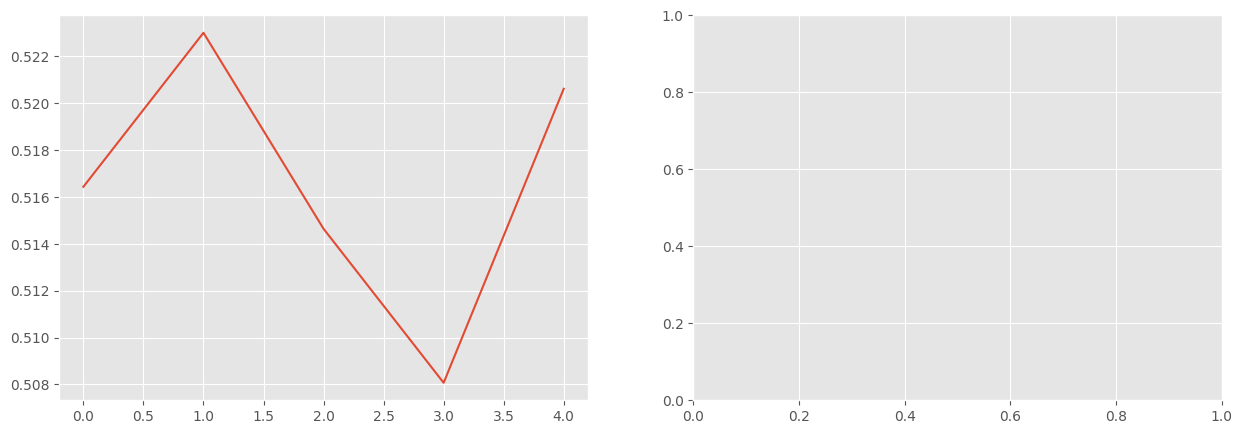

In [24]:
# --- Plot the training history ---
import matplotlib.pyplot as plt
plt.style.use("ggplot")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot training & validation accuracy values
ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend()

# Plot training & validation loss values
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend()

plt.show()